### Parameter $\theta$ Estimation

Generating Simulation Data
Theta Inference Starts


Processing: 100%|██████████| 100/100 [1:01:05<00:00, 36.66s/it]


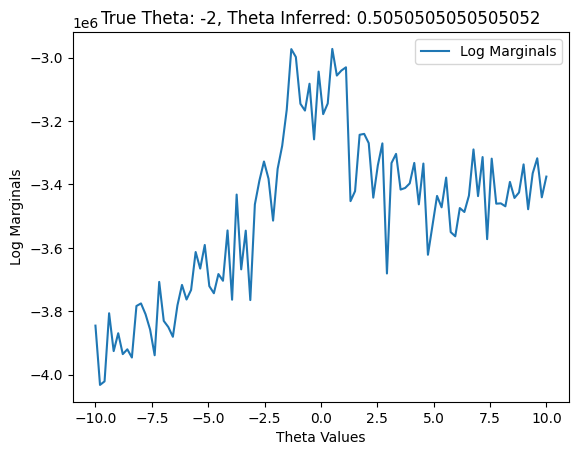

In [5]:
import numpy as np
from scipy.linalg import expm #This is the automatic matrix expnent solver
from jump_process_generators import *
import matplotlib.pyplot as plt
from NVM_state_space import *
from NVM_state_space_filters import *
from basic_tools import *
from scipy.special import logsumexp
from tqdm import tqdm  # 导入tqdm
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:

print("Generating Simulation Data")
searching_resolution = 100
thetas = np.linspace(-10,10,searching_resolution)  #The searching range
true_theta = -2 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.0001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 1
true_muw = 1
sigma_n = true_sigmaw * np.sqrt(kv)

num_particles = 100


#Simulation Parameters

beta = 5
C = 10
T = 100


N = 1000  # Resolution

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(beta, C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form




log_scores = []
#progress = 0
print("Theta Inference Starts")
for theta in tqdm(thetas, desc="Processing"):
    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    sigmaw_uncertainties = []
    total_log_marginals = np.zeros(num_particles)

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        alphaw = weighted_sum(alphaws,weights)
        betaw = weighted_sum(betaws,weights)
        sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
        sigmaw_uncertainties.append(sigmaw_uncertainty)


        incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)
        total_log_marginals += log_marginals

    overall_log_score = logsumexp(total_log_marginals) - np.log(num_particles)
    log_scores.append(overall_log_score)


# 计算完成后，找到最大log score对应的theta
max_log_score_index = np.argmax(log_scores)
max_likelihood_theta = thetas[max_log_score_index]

# 绘制结果并在标题中显示true_theta和最大似然估计的theta值
plt.plot(thetas, log_scores, label='Log Marginals')
plt.xlabel("Theta Values")
plt.ylabel("Log Marginals")
plt.title(f"True Theta: {true_theta}, Theta Inferred: {max_likelihood_theta}")
plt.legend()
plt.show()

























### Inference under longer time scale

Generating Simulation Data
Theta Inference Starts


Processing: 100%|██████████| 100/100 [1:00:35<00:00, 36.36s/it]


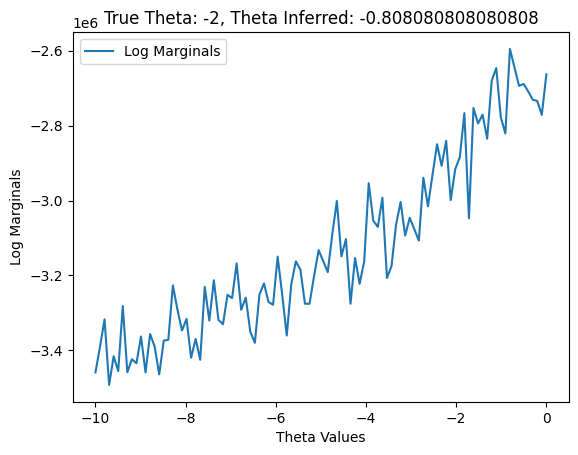

In [6]:
import numpy as np
from scipy.linalg import expm #This is the automatic matrix expnent solver
from jump_process_generators import *
import matplotlib.pyplot as plt
from NVM_state_space import *
from NVM_state_space_filters import *
from basic_tools import *
from scipy.special import logsumexp
from tqdm import tqdm  # 导入tqdm
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:

print("Generating Simulation Data")
searching_resolution = 100
thetas = np.linspace(-10,0,searching_resolution)  #The searching range
true_theta = -2 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.0001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 0.5
true_muw = 0.5
sigma_n = true_sigmaw * np.sqrt(kv)

num_particles = 100


#Simulation Parameters

beta = 5
C = 10
T = 100


N = 1000  # Resolution

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(beta, C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form




log_scores = []
#progress = 0
print("Theta Inference Starts")
for theta in tqdm(thetas, desc="Processing"):
    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    sigmaw_uncertainties = []
    total_log_marginals = np.zeros(num_particles)

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        alphaw = weighted_sum(alphaws,weights)
        betaw = weighted_sum(betaws,weights)
        sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
        sigmaw_uncertainties.append(sigmaw_uncertainty)


        incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)
        total_log_marginals += log_marginals

    overall_log_score = logsumexp(total_log_marginals) - np.log(num_particles)
    log_scores.append(overall_log_score)


# 计算完成后，找到最大log score对应的theta
max_log_score_index = np.argmax(log_scores)
max_likelihood_theta = thetas[max_log_score_index]

# 绘制结果并在标题中显示true_theta和最大似然估计的theta值
plt.plot(thetas, log_scores, label='Log Marginals')
plt.xlabel("Theta Values")
plt.ylabel("Log Marginals")
plt.title(f"True Theta: {true_theta}, Theta Inferred: {max_likelihood_theta}")
plt.legend()
plt.show()

























Generating Simulation Data
Theta Inference Starts


Processing: 100%|██████████| 100/100 [1:01:23<00:00, 36.84s/it]


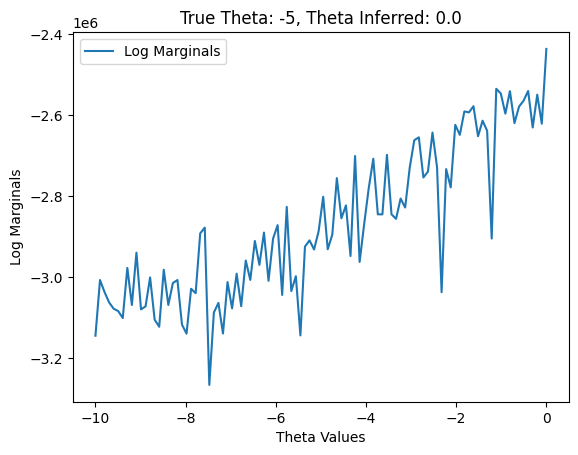

In [7]:
import numpy as np
from scipy.linalg import expm #This is the automatic matrix expnent solver
from jump_process_generators import *
import matplotlib.pyplot as plt
from NVM_state_space import *
from NVM_state_space_filters import *
from basic_tools import *
from scipy.special import logsumexp
from tqdm import tqdm  # 导入tqdm
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:

print("Generating Simulation Data")
searching_resolution = 100
thetas = np.linspace(-10,0,searching_resolution)  #The searching range
true_theta = -5 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.0001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 0.5
true_muw = 0.5
sigma_n = true_sigmaw * np.sqrt(kv)

num_particles = 100


#Simulation Parameters

beta = 5
C = 10
T = 100


N = 1000  # Resolution

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(beta, C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form




log_scores = []
#progress = 0
print("Theta Inference Starts")
for theta in tqdm(thetas, desc="Processing"):
    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    sigmaw_uncertainties = []
    total_log_marginals = np.zeros(num_particles)

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        alphaw = weighted_sum(alphaws,weights)
        betaw = weighted_sum(betaws,weights)
        sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
        sigmaw_uncertainties.append(sigmaw_uncertainty)


        incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)
        total_log_marginals += log_marginals

    overall_log_score = logsumexp(total_log_marginals) - np.log(num_particles)
    log_scores.append(overall_log_score)


# 计算完成后，找到最大log score对应的theta
max_log_score_index = np.argmax(log_scores)
max_likelihood_theta = thetas[max_log_score_index]

# 绘制结果并在标题中显示true_theta和最大似然估计的theta值
plt.plot(thetas, log_scores, label='Log Marginals')
plt.xlabel("Theta Values")
plt.ylabel("Log Marginals")
plt.title(f"True Theta: {true_theta}, Theta Inferred: {max_likelihood_theta}")
plt.legend()
plt.show()

























In [8]:
import numpy as np
from scipy.linalg import expm #This is the automatic matrix expnent solver
from jump_process_generators import *
import matplotlib.pyplot as plt
from NVM_state_space import *
from NVM_state_space_filters import *
from basic_tools import *
from scipy.special import logsumexp
from tqdm import tqdm  # 导入tqdm
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:

print("Generating Simulation Data")
searching_resolution = 100
thetas = np.linspace(-20,10,searching_resolution)  #The searching range
true_theta = -10 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.0001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 0.5
true_muw = 0.5
sigma_n = true_sigmaw * np.sqrt(kv)

num_particles = 100


#Simulation Parameters

beta = 5
C = 10
T = 100


N = 1000  # Resolution

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(beta, C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form




log_scores = []
#progress = 0
print("Theta Inference Starts")
for theta in tqdm(thetas, desc="Processing"):
    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    sigmaw_uncertainties = []
    total_log_marginals = np.zeros(num_particles)

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        alphaw = weighted_sum(alphaws,weights)
        betaw = weighted_sum(betaws,weights)
        sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
        sigmaw_uncertainties.append(sigmaw_uncertainty)


        incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)
        total_log_marginals += log_marginals

    overall_log_score = logsumexp(total_log_marginals) - np.log(num_particles)
    log_scores.append(overall_log_score)


# 计算完成后，找到最大log score对应的theta
max_log_score_index = np.argmax(log_scores)
max_likelihood_theta = thetas[max_log_score_index]

# 绘制结果并在标题中显示true_theta和最大似然估计的theta值
plt.plot(thetas, log_scores, label='Log Marginals')
plt.xlabel("Theta Values")
plt.ylabel("Log Marginals")
plt.title(f"True Theta: {true_theta}, Theta Inferred: {max_likelihood_theta}")
plt.legend()
plt.show()

























Generating Simulation Data


KeyboardInterrupt: 

Processing: 100%|██████████| 10/10 [06:18<00:00, 37.84s/it]


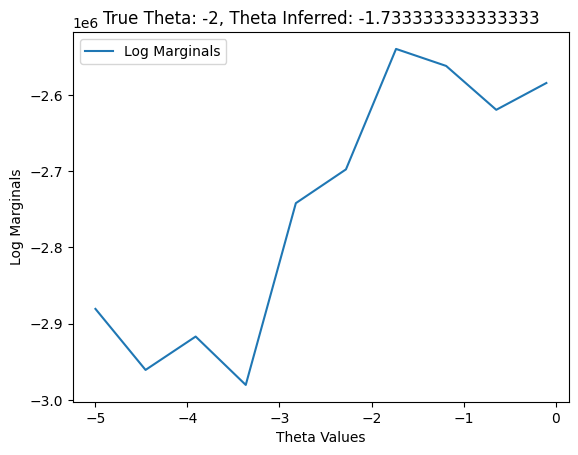

In [9]:
import numpy as np
from scipy.linalg import expm #This is the automatic matrix expnent solver
from jump_process_generators import *
import matplotlib.pyplot as plt
from NVM_state_space import *
from NVM_state_space_filters import *
from basic_tools import *
from scipy.special import logsumexp
from tqdm import tqdm  # 导入tqdm
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:


searching_resolution = 10
thetas = np.linspace(-5,-0.1,searching_resolution)  #The searching range
true_theta = -2 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 2
true_muw = 0.2
sigma_n = true_sigmaw * np.sqrt(kv)

num_particles = 100


#Simulation Parameters

beta = 5
C = 10
T = 100


N = 1000  # Resolution

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(beta, C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form




log_scores = []
#progress = 0
for theta in tqdm(thetas, desc="Processing"):
    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    sigmaw_uncertainties = []
    total_log_marginals = np.zeros(num_particles)

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        alphaw = weighted_sum(alphaws,weights)
        betaw = weighted_sum(betaws,weights)
        sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
        sigmaw_uncertainties.append(sigmaw_uncertainty)


        incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)
        total_log_marginals += log_marginals

    overall_log_score = logsumexp(total_log_marginals) - np.log(num_particles)
    log_scores.append(overall_log_score)


# 计算完成后，找到最大log score对应的theta
max_log_score_index = np.argmax(log_scores)
max_likelihood_theta = thetas[max_log_score_index]

# 绘制结果并在标题中显示true_theta和最大似然估计的theta值
plt.plot(thetas, log_scores, label='Log Marginals')
plt.xlabel("Theta Values")
plt.ylabel("Log Marginals")
plt.title(f"True Theta: {true_theta}, Theta Inferred: {max_likelihood_theta}")
plt.legend()
plt.show()

























Processing: 100%|██████████| 100/100 [1:02:21<00:00, 37.42s/it]


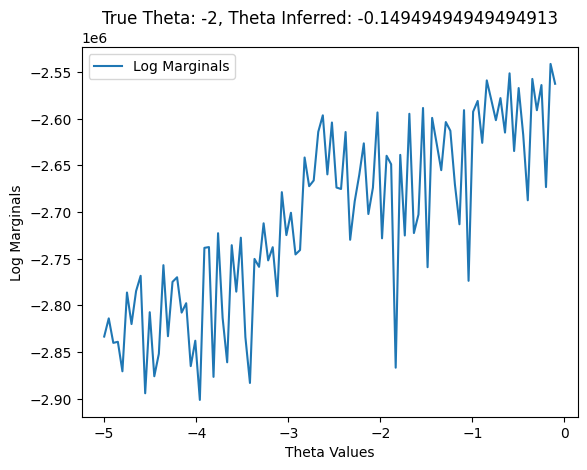

In [10]:
import numpy as np
from scipy.linalg import expm #This is the automatic matrix expnent solver
from jump_process_generators import *
import matplotlib.pyplot as plt
from NVM_state_space import *
from NVM_state_space_filters import *
from basic_tools import *
from scipy.special import logsumexp
from tqdm import tqdm  # 导入tqdm
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:


searching_resolution = 100
thetas = np.linspace(-5,-0.1,searching_resolution)  #The searching range
true_theta = -2 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 2
true_muw = 0.2
sigma_n = true_sigmaw * np.sqrt(kv)

num_particles = 100


#Simulation Parameters

beta = 5
C = 10
T = 100


N = 1000  # Resolution

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(beta, C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form




log_scores = []
#progress = 0
for theta in tqdm(thetas, desc="Processing"):
    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    sigmaw_uncertainties = []
    total_log_marginals = np.zeros(num_particles)

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        alphaw = weighted_sum(alphaws,weights)
        betaw = weighted_sum(betaws,weights)
        sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
        sigmaw_uncertainties.append(sigmaw_uncertainty)


        incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)
        total_log_marginals += log_marginals

    overall_log_score = logsumexp(total_log_marginals) - np.log(num_particles)
    log_scores.append(overall_log_score)


# 计算完成后，找到最大log score对应的theta
max_log_score_index = np.argmax(log_scores)
max_likelihood_theta = thetas[max_log_score_index]

# 绘制结果并在标题中显示true_theta和最大似然估计的theta值
plt.plot(thetas, log_scores, label='Log Marginals')
plt.xlabel("Theta Values")
plt.ylabel("Log Marginals")
plt.title(f"True Theta: {true_theta}, Theta Inferred: {max_likelihood_theta}")
plt.legend()
plt.show()

























Processing: 100%|██████████| 100/100 [57:03<00:00, 34.24s/it]


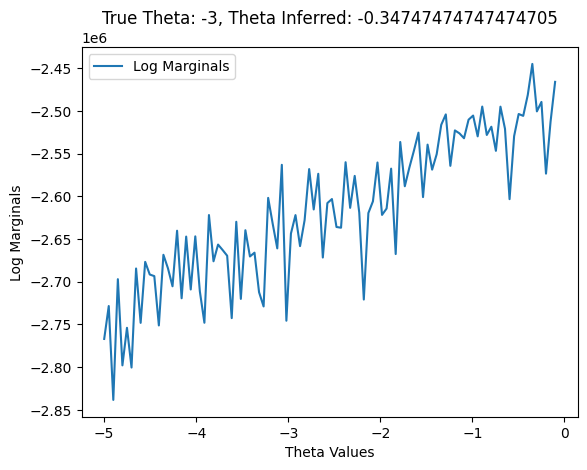

In [1]:
import numpy as np
from scipy.linalg import expm #This is the automatic matrix expnent solver
from jump_process_generators import *
import matplotlib.pyplot as plt
from NVM_state_space import *
from NVM_state_space_filters import *
from basic_tools import *
from scipy.special import logsumexp
from tqdm import tqdm  # 导入tqdm
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:


searching_resolution = 100
thetas = np.linspace(-5,-0.1,searching_resolution)  #The searching range
true_theta = -3 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 2
true_muw = 0.2
sigma_n = true_sigmaw * np.sqrt(kv)

num_particles = 100


#Simulation Parameters

beta = 5
C = 10
T = 100


N = 1000  # Resolution

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(beta, C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form




log_scores = []
#progress = 0
for theta in tqdm(thetas, desc="Processing"):
    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    sigmaw_uncertainties = []
    total_log_marginals = np.zeros(num_particles)

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        alphaw = weighted_sum(alphaws,weights)
        betaw = weighted_sum(betaws,weights)
        sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
        sigmaw_uncertainties.append(sigmaw_uncertainty)


        incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)
        total_log_marginals += log_marginals

    overall_log_score = logsumexp(total_log_marginals) - np.log(num_particles)
    log_scores.append(overall_log_score)


# 计算完成后，找到最大log score对应的theta
max_log_score_index = np.argmax(log_scores)
max_likelihood_theta = thetas[max_log_score_index]

# 绘制结果并在标题中显示true_theta和最大似然估计的theta值
plt.plot(thetas, log_scores, label='Log Marginals')
plt.xlabel("Theta Values")
plt.ylabel("Log Marginals")
plt.title(f"True Theta: {true_theta}, Theta Inferred: {max_likelihood_theta}")
plt.legend()
plt.show()

























In [2]:
import numpy as np
from scipy.linalg import expm #This is the automatic matrix expnent solver
from jump_process_generators import *
import matplotlib.pyplot as plt
from NVM_state_space import *
from NVM_state_space_filters import *
from basic_tools import *
from scipy.special import logsumexp
from tqdm import tqdm  # 导入tqdm
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:


searching_resolution = 100
thetas = np.linspace(-5,10,searching_resolution)  #The searching range
true_theta = 6 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 2
true_muw = 0.2
sigma_n = true_sigmaw * np.sqrt(kv)

num_particles = 100


#Simulation Parameters

beta = 5
C = 10
T = 100


N = 1000  # Resolution

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(beta, C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form




log_scores = []
#progress = 0
for theta in tqdm(thetas, desc="Processing"):
    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    sigmaw_uncertainties = []
    total_log_marginals = np.zeros(num_particles)

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        alphaw = weighted_sum(alphaws,weights)
        betaw = weighted_sum(betaws,weights)
        sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
        sigmaw_uncertainties.append(sigmaw_uncertainty)


        incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)
        total_log_marginals += log_marginals

    overall_log_score = logsumexp(total_log_marginals) - np.log(num_particles)
    log_scores.append(overall_log_score)


# 计算完成后，找到最大log score对应的theta
max_log_score_index = np.argmax(log_scores)
max_likelihood_theta = thetas[max_log_score_index]

# 绘制结果并在标题中显示true_theta和最大似然估计的theta值
plt.plot(thetas, log_scores, label='Log Marginals')
plt.xlabel("Theta Values")
plt.ylabel("Log Marginals")
plt.title(f"True Theta: {true_theta}, Theta Inferred: {max_likelihood_theta}")
plt.legend()
plt.show()

























Processing:   0%|          | 0/100 [00:00<?, ?it/s]/Users/bill/Desktop/Cambridge/IIB/IIB_Project/Codes/IIB_Codes/basic_tools.py:71: RuntimeWarning: overflow encountered in square
  variance = max(0,beta**2 / ((alpha - 1)**2 * (alpha - 2)))
/Users/bill/Desktop/Cambridge/IIB/IIB_Project/Codes/IIB_Codes/NVM_state_space_filters.py:875: RuntimeWarning: overflow encountered in add
  log_marginal = -M*N/2*np.log(2*np.pi) - accumulated_Fs[i]-0.5*log_det_F + alphaw * np.log(betaw) - (alphaw+N/2)*np.log(betaw + accumulated_Es[i]/2+Ei/2) + gammaln(N/2 + alphaw) - gammaln(alphaw)
/Users/bill/Desktop/Cambridge/IIB/IIB_Project/Codes/IIB_Codes/basic_tools.py:34: RuntimeWarning: invalid value encountered in subtract
  normalized_log_likelihoods = log_likelihoods - normalization_factor
Processing:   0%|          | 0/100 [00:19<?, ?it/s]


ValueError: probabilities contain NaN